# [Housing Prices Competition for Kaggle Learn Users](https://www.kaggle.com/c/home-data-for-ml-course/overview)

## Competition Description


Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

### Practice Skills
Creative feature engineering 
Advanced regression techniques like random forest and gradient boosting
### Acknowledgments
The Ames Housing dataset was compiled by Dean De Cock for use in data science education. It's an incredible alternative for data scientists looking for a modernized and expanded version of the often cited Boston Housing dataset. 

In [10]:
!pip install kaggle --upgrade
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c home-data-for-ml-course

  0% 0.00/31.2k [00:00<?, ?B/s]
100% 31.2k/31.2k [00:00<00:00, 52.0MB/s]
  0% 0.00/450k [00:00<?, ?B/s]
100% 450k/450k [00:00<00:00, 63.0MB/s]
  0% 0.00/15.3k [00:00<?, ?B/s]
100% 15.3k/15.3k [00:00<00:00, 15.4MB/s]
  0% 0.00/13.1k [00:00<?, ?B/s]
100% 13.1k/13.1k [00:00<00:00, 26.4MB/s]
  0% 0.00/82.0k [00:00<?, ?B/s]
100% 82.0k/82.0k [00:00<00:00, 83.2MB/s]
  0% 0.00/441k [00:00<?, ?B/s]
100% 441k/441k [00:00<00:00, 63.8MB/s]
  0% 0.00/89.2k [00:00<?, ?B/s]
100% 89.2k/89.2k [00:00<00:00, 92.5MB/s]


In [14]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

In [15]:
# Read the data
X_full = pd.read_csv('/content/train.csv', index_col='Id')
X_test_full = pd.read_csv('/content/test.csv', index_col='Id')

# Remove rows with missing target, separate target from predictors
X_full.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = X_full.SalePrice
X_full.drop(['SalePrice'], axis=1, inplace=True)

# Break off validation set from training data
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X_full, y, 
                                                                train_size=0.8, test_size=0.2,
                                                                random_state=0)

# Select categorical columns with relatively low cardinality 
categorical_cols = [cname for cname in X_train_full.columns if
                    X_train_full[cname].nunique() < 10 and 
                    X_train_full[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in X_train_full.columns if 
                X_train_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = categorical_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()
X_test = X_test_full[my_cols].copy()

In [16]:
X_train.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
619,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Norm,Norm,1Fam,1Story,Hip,CompShg,BrkFace,Ex,TA,PConc,Ex,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Gd,Attchd,Unf,TA,TA,Y,NaN,NaN,NaN,New,Partial,20,90.0,11694,9,5,2007,2007,452.0,48,0,1774,1822,1828,0,0,1828,0,0,2,0,3,1,9,1,2007.0,3,774,0,108,0,0,260,0,0,7,2007
871,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,PosN,Norm,1Fam,1Story,Hip,CompShg,None,TA,TA,CBlock,TA,TA,No,Unf,Unf,GasA,Gd,N,SBrkr,TA,Typ,NaN,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Normal,20,60.0,6600,5,5,1962,1962,0.0,0,0,894,894,894,0,0,894,0,0,1,0,2,1,5,0,1962.0,1,308,0,0,0,0,0,0,0,8,2009
93,RL,Pave,Grvl,IR1,HLS,AllPub,Inside,Gtl,Norm,Norm,1Fam,1Story,Gable,CompShg,None,TA,Gd,BrkTil,Gd,TA,No,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,NaN,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Normal,30,80.0,13360,5,7,1921,2006,0.0,713,0,163,876,964,0,0,964,1,0,1,0,2,1,5,0,1921.0,2,432,0,0,44,0,0,0,0,8,2009
818,RL,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Norm,Norm,1Fam,1Story,Hip,CompShg,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Gd,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal,20,NaN,13265,8,5,2002,2002,148.0,1218,0,350,1568,1689,0,0,1689,1,0,2,0,3,1,7,2,2002.0,3,857,150,59,0,0,0,0,0,7,2008
303,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Norm,Norm,1Fam,1Story,Gable,CompShg,BrkFace,Gd,TA,PConc,Gd,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal,20,118.0,13704,7,5,2001,2002,150.0,0,0,1541,1541,1541,0,0,1541,0,0,2,0,3,1,6,1,2001.0,3,843,468,81,0,0,0,0,0,1,2006


In [17]:
#Determine best n_estimators for RandomForestRegressor
X = X_train[numerical_cols].copy()

# print(X_train.shape, y_train.shape)
def get_score(n_estimators):
    """Return the average MAE over 3 CV folds of random forest model.

    Keyword argument:
    n_estimators -- the number of trees in the forest
    """
    my_pipeline = Pipeline(steps = [
        ("preprocessor", SimpleImputer()),
        ("model", RandomForestRegressor(n_estimators, random_state = 0))
    ])
    scores = -1*cross_val_score(my_pipeline, X, y_train, 
                               cv = 3, scoring = 'neg_mean_absolute_error')
    return scores.mean()

# Select the n_estimator value with least mae
estimators = list(range(50, 401, 50)) # Your code here
results = {}
for n in estimators:
    results[n] = get_score(n)
    print("Done: ", n)

Done:  50
Done:  100
Done:  150
Done:  200
Done:  250
Done:  300
Done:  350
Done:  400


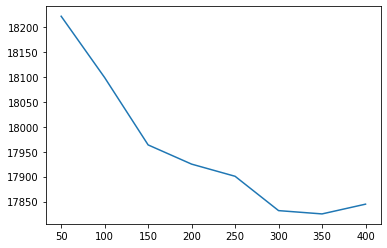

In [18]:
# Print the results
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(list(results.keys()), list(results.values()))
plt.show()

In [19]:
# RANDOM FOREST REGRESSOR MODEL

# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='constant')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Define model
model = RandomForestRegressor(n_estimators= 350, random_state=0)

# Bundle preprocessing and modeling code in a pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)
                     ])

# Preprocessing of training data, fit model 
clf.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = clf.predict(X_valid)

print('MAE:', mean_absolute_error(y_valid, preds))

MAE: 17468.252230919763


In [20]:
# Save test predictions to file
preds_test = clf.predict(X_test) # Your code here
output = pd.DataFrame({'Id': X_test.index,
                       'SalePrice': preds_test})
output.to_csv('submission_rfr.csv', index=False)

In [21]:
# XGB REGRESSOR MODEL


# One-hot encode the data (to shorten the code, we use pandas)
X_train = pd.get_dummies(X_train)
X_valid = pd.get_dummies(X_valid)
X_test = pd.get_dummies(X_test)
X_train, X_valid = X_train.align(X_valid, join='left', axis=1)
X_train, X_test = X_train.align(X_test, join='left', axis=1)

# Define the model
model_2 = XGBRegressor(n_estimators = 1000, learning_rate = 0.05)

# Fit the model
model_2.fit(X_train, y_train,
              early_stopping_rounds = 100,
              eval_set = [(X_valid, y_valid)],
           verbose = False)

# Get predictions
predictions_2 = model_2.predict(X_valid)

# Calculate MAE
mae_2 = mean_absolute_error(predictions_2, y_valid)

# Uncomment to print MAE
print("Mean Absolute Error:" , mae_2)

[11:04:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean Absolute Error: 16084.123354559075


In [23]:
# Save test predictions to file
preds_test = model_2.predict(X_test) # Your code here
output = pd.DataFrame({'Id': X_test.index,
                       'SalePrice': preds_test})
output.to_csv('submission_xgbr.csv', index=False)